In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

class TimeSeriesData():
    def __init__(self,num_points,xmin,xmax):
        self.xmin=xmin
        self.xmax=xmax
        self.num_points=num_points
        self.resolution=(xmax-xmin)/num_points
        self.x_data=np.linspace(xmin,xmax,num_points)
        self.y_true=np.sin(self.x_data)
    def ret_true(self,x_series):
        return np.sin(x_series)
    def next_batch(self,batch_size,steps,return_batch_ts=False):
        #random starting point for each batch
        rand_start=np.random.rand(batch_size,1)
        #convert to time series
        ts_start=rand_start*(self.xmax - self.xmin -(steps*self.resolution))
        #create batch time series on x axis
        batch_ts=ts_start+np.arange(0.0,steps+1) * self.resolution
        #create y data for time series x axis from prev step
        y_batch=np.sin(batch_ts)
        #formatting for rnn
        if return_batch_ts:
            return y_batch[:,:-1].reshape(-1,steps,1), y_batch[:,1:].reshape(-1,steps,1), batch_ts
        else:
            return y_batch[:,:-1].reshape(-1,steps,1), y_batch[:,1:].reshape(-1,steps,1)
        

In [0]:
ts_data=TimeSeriesData(250,0,10)

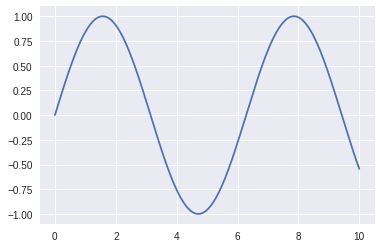

In [3]:
plt.plot(ts_data.x_data,ts_data.y_true)

In [0]:
num_time_steps=30

In [0]:
y1,y2,ts=ts_data.next_batch(1,num_time_steps,True)

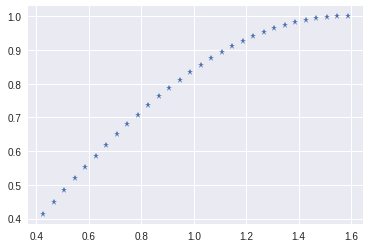

In [6]:
plt.plot(ts.flatten()[1:],y2.flatten(),'*')

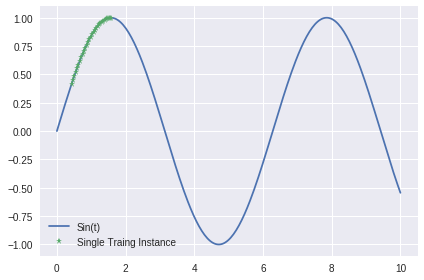

In [7]:
plt.plot(ts_data.x_data,ts_data.y_true,label='Sin(t)')
plt.plot(ts.flatten()[1:],y2.flatten(),'*',label='Single Traing Instance')
plt.legend()
plt.tight_layout()

In [8]:
#training data
train_inst=np.linspace(5,5 + ts_data.resolution*(num_time_steps+1),num_time_steps+1)
train_inst

array([5.        , 5.04133333, 5.08266667, 5.124     , 5.16533333,
       5.20666667, 5.248     , 5.28933333, 5.33066667, 5.372     ,
       5.41333333, 5.45466667, 5.496     , 5.53733333, 5.57866667,
       5.62      , 5.66133333, 5.70266667, 5.744     , 5.78533333,
       5.82666667, 5.868     , 5.90933333, 5.95066667, 5.992     ,
       6.03333333, 6.07466667, 6.116     , 6.15733333, 6.19866667,
       6.24      ])

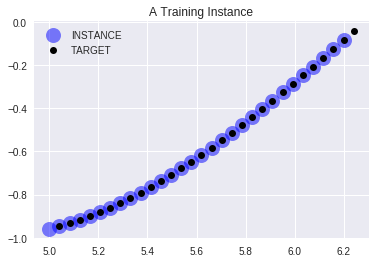

In [9]:
plt.title('A Training Instance')
plt.plot(train_inst[:-1],ts_data.ret_true(train_inst[:-1]), 'bo', markersize=15, alpha=0.5,label='INSTANCE')
plt.plot(train_inst[1:],ts_data.ret_true(train_inst[1:]), 'ko', markersize=7,label='TARGET')
plt.legend()

In [0]:
#note - pooling layer decrease the special dimension

In [0]:
num_inputs=1
num_neurons=100 #100
num_outputs=1
learning_rate=0.001
num_train_iteration=2000 #default 2000
batch_size=1

In [0]:
x=tf.placeholder(tf.float32,[None,num_time_steps,num_inputs])
y=tf.placeholder(tf.float32,[None,num_time_steps,num_outputs])

In [14]:
#rnn cell layer
cell=tf.contrib.rnn.GRUCell(num_units=num_neurons, activation=tf.nn.relu)
cell=tf.contrib.rnn.OutputProjectionWrapper(cell,output_size=num_outputs)

Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.


In [15]:
outputs, states = tf.nn.dynamic_rnn(cell,x,dtype=tf.float32)

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.


In [16]:
loss=tf.reduce_mean(tf.square(outputs-y))
optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate)
train=optimizer.minimize(loss)
init=tf.global_variables_initializer()
saver=tf.train.Saver()

with tf.Session() as sess:
    sess.run(init)
    for iteration in range(num_train_iteration):
        x_batch,y_batch=ts_data.next_batch(batch_size,num_time_steps)
        sess.run(train,feed_dict={x:x_batch,y:y_batch})
        if iteration % 100 == 0:
            mse=loss.eval(feed_dict={x:x_batch,y:y_batch})
            print(iteration,'\tMSE',mse)
        saver.save(sess,'./rnn_tine_series_model')

0 	MSE 0.32990834
100 	MSE 0.04746436
200 	MSE 0.03519166
300 	MSE 0.002674935
400 	MSE 0.0016100012
500 	MSE 0.009111399
600 	MSE 0.009789336
700 	MSE 0.00021224107
800 	MSE 0.00060287374
900 	MSE 0.0026266938
1000 	MSE 0.0014959973
1100 	MSE 0.00046574575
1200 	MSE 0.0003650541
1300 	MSE 0.00020677353
1400 	MSE 9.056918e-05
1500 	MSE 0.00024159664
1600 	MSE 0.00013348163
1700 	MSE 5.4764525e-05
1800 	MSE 1.875438e-05
1900 	MSE 4.68845e-05


In [17]:
with tf.Session() as sess:
  saver.restore(sess, './rnn_tine_series_model')
  x_new=np.sin(np.array(train_inst[:-1].reshape(-1,num_time_steps,num_inputs)))
  y_pred=sess.run(outputs,feed_dict={x:x_new})

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./rnn_tine_series_model


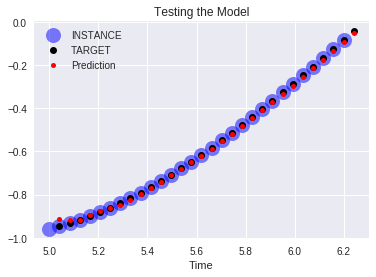

In [18]:
plt.title('Testing the Model')
plt.plot(train_inst[:-1],ts_data.ret_true(train_inst[:-1]), 'bo', markersize=15, alpha=0.5,label='INSTANCE')
plt.plot(train_inst[1:],ts_data.ret_true(train_inst[1:]), 'ko', markersize=7,label='TARGET')
plt.plot(train_inst[1:],y_pred[0,:,0],'r.',markersize=10,label='Prediction')
plt.xlabel('Time')
plt.legend()

In [20]:
#generate new sequence
with tf.Session() as sess:
  saver.restore(sess,'./rnn_tine_series_model')
  zero_seq_seed=[0.0 for i in range(num_time_steps)]
  for iteration in range(len(ts_data.x_data)-num_time_steps):
    x_batch=np.array(zero_seq_seed[-num_time_steps:]).reshape(1,num_time_steps,1)
    y_pred=sess.run(outputs,feed_dict={x:x_batch})
    zero_seq_seed.append(y_pred[0,-1,0])


INFO:tensorflow:Restoring parameters from ./rnn_tine_series_model


Text(0, 0.5, 'Y')

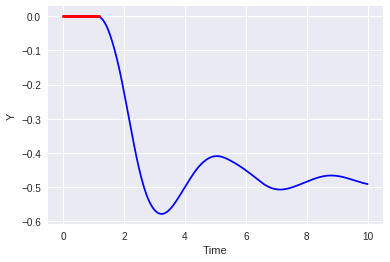

In [21]:
plt.plot(ts_data.x_data,zero_seq_seed,'b-')
plt.plot(ts_data.x_data[:num_time_steps],zero_seq_seed[:num_time_steps],
        'r',linewidth=3)
plt.xlabel('Time')
plt.ylabel('Y')

In [22]:
#generate new sequence
with tf.Session() as sess:
  saver.restore(sess,'./rnn_tine_series_model')
  train_instance=list(ts_data.y_true[:30])
  for iteration in range(len(train_instance)-num_time_steps):
    x_batch=np.array(train_instance[-num_time_steps:]).reshape(1,num_time_steps,1)
    y_pred=sess.run(outputs,feed_dict={x:x_batch})
    train_instance.append(y_pred[0,-1,0])

INFO:tensorflow:Restoring parameters from ./rnn_tine_series_model


Text(0, 0.5, 'Y')

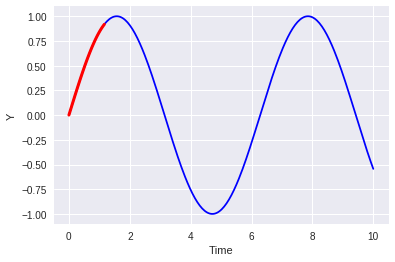

In [24]:
plt.plot(ts_data.x_data,ts_data.y_true,'b-')
plt.plot(ts_data.x_data[:num_time_steps],train_instance[:num_time_steps],
        'r',linewidth=3)
plt.xlabel('Time')
plt.ylabel('Y')